1. 사전설정 및 데이터 다운로드

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kimis13","key":"a520fe22f2314a69a8f94a464b80e566"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!mkdir /content/gdrive/My\ Drive/.kaggle/
!mv kaggle.json /content/gdrive/My\ Drive/.kaggle/
!chmod 600 /content/gdrive/My\ Drive/.kaggle/kaggle.json
! cp -r /content/gdrive/My\ Drive/.kaggle/ /root/

Mounted at /content/gdrive
mkdir: cannot create directory ‘/content/gdrive/My Drive/.kaggle/’: File exists


In [ ]:
!mkdir /content/gdrive/My\ Drive/brain_tumor_mri_dataset
!mv brain-tumor-mri-dataset.zip /content/gdrive/My\ Drive/brain_tumor_mri_dataset
%cd /content/gdrive/My\ Drive/brain_tumor_mri_dataset

mkdir: cannot create directory ‘/content/gdrive/My Drive/brain_tumor_mri_dataset’: File exists
mv: cannot stat 'brain-tumor-mri-dataset.zip': No such file or directory
/content/gdrive/My Drive/brain_tumor_mri_dataset


2. 필요한 라이브러리 설치

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
3. 이미지 사전 처리
ImageDataGenerator: 데이터 증강을 위한 클래스, 사진의 밝기 및 해상도 조절 등을 수행

In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])
    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
train_path=train_df('/content/gdrive/My Drive/brain_tumor_mri_dataset/Training')
test_path=test_df('/content/gdrive/My Drive/brain_tumor_mri_dataset/Testing')

In [ ]:
train_set, valid_set=train_test_split(train_path, test_size=0.2, random_state=42, stratify=train_path['Class'])

In [ ]:
batch_size=32
img_size=(128,128)
_gen=ImageDataGenerator(rescale=1./255)
train_gen=_gen.flow_from_dataframe(train_set, x_col='Class Path', y_col='Class', target_size=img_size, batch_size=batch_size)
valid_gen=_gen.flow_from_dataframe(valid_set, x_col='Class Path', y_col='Class', target_size=img_size, batch_size=batch_size)
test_gen=_gen.flow_from_dataframe(test_path, x_col='Class Path', y_col='Class', target_size=img_size, batch_size=16, shuffle=False)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


4. Xception 기반 모델 빌드


In [ ]:
img_shape=(128,128,3)
base_model=tf.keras.applications.Xception(input_shape=img_shape, include_top=False, weights='imagenet', pooling='max')
model=Sequential([
    base_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

In [ ]:
model.compile(optimizer=Adamax(), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [ ]:
train_model=model.fit(train_gen,
                      epochs=10,
                      validation_data=valid_gen,
                      shuffle=False)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1931s 13s/step - accuracy: 0.8008 - loss: 0.5605 - precision_1: 0.8571 - recall_1: 0.7068 - val_accuracy: 0.9020 - val_loss: 0.3768 - val_precision_1: 0.9080 - val_recall_1: 0.8976
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - accuracy: 0.9678 - loss: 0.0881 - precision_1: 0.9697 - recall_1: 0.9648 - val_accuracy: 0.9475 - val_loss: 0.1506 - val_precision_1: 0.9517 - val_recall_1: 0.9475
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 206ms/step - accuracy: 0.9876 - loss: 0.0451 - precision_1: 0.9879 - recall_1: 0.9866 - val_accuracy: 0.9703 - val_loss: 0.1304 - val_precision_1: 0.9719 - val_recall_1: 0.9685
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 209ms/step - accuracy: 0.9918 - loss: 0.0278 - precision_1: 0.9925 - recall_1: 0.9912 - val_accuracy: 0.9720 - val_loss: 0.0901 - val_precision_1: 0.9729 - val_recall_1: 0.9720
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - accuracy: 0.9949 - loss: 0.0167 - precision_1: 0.9949 - rec

5. 성능 시각화

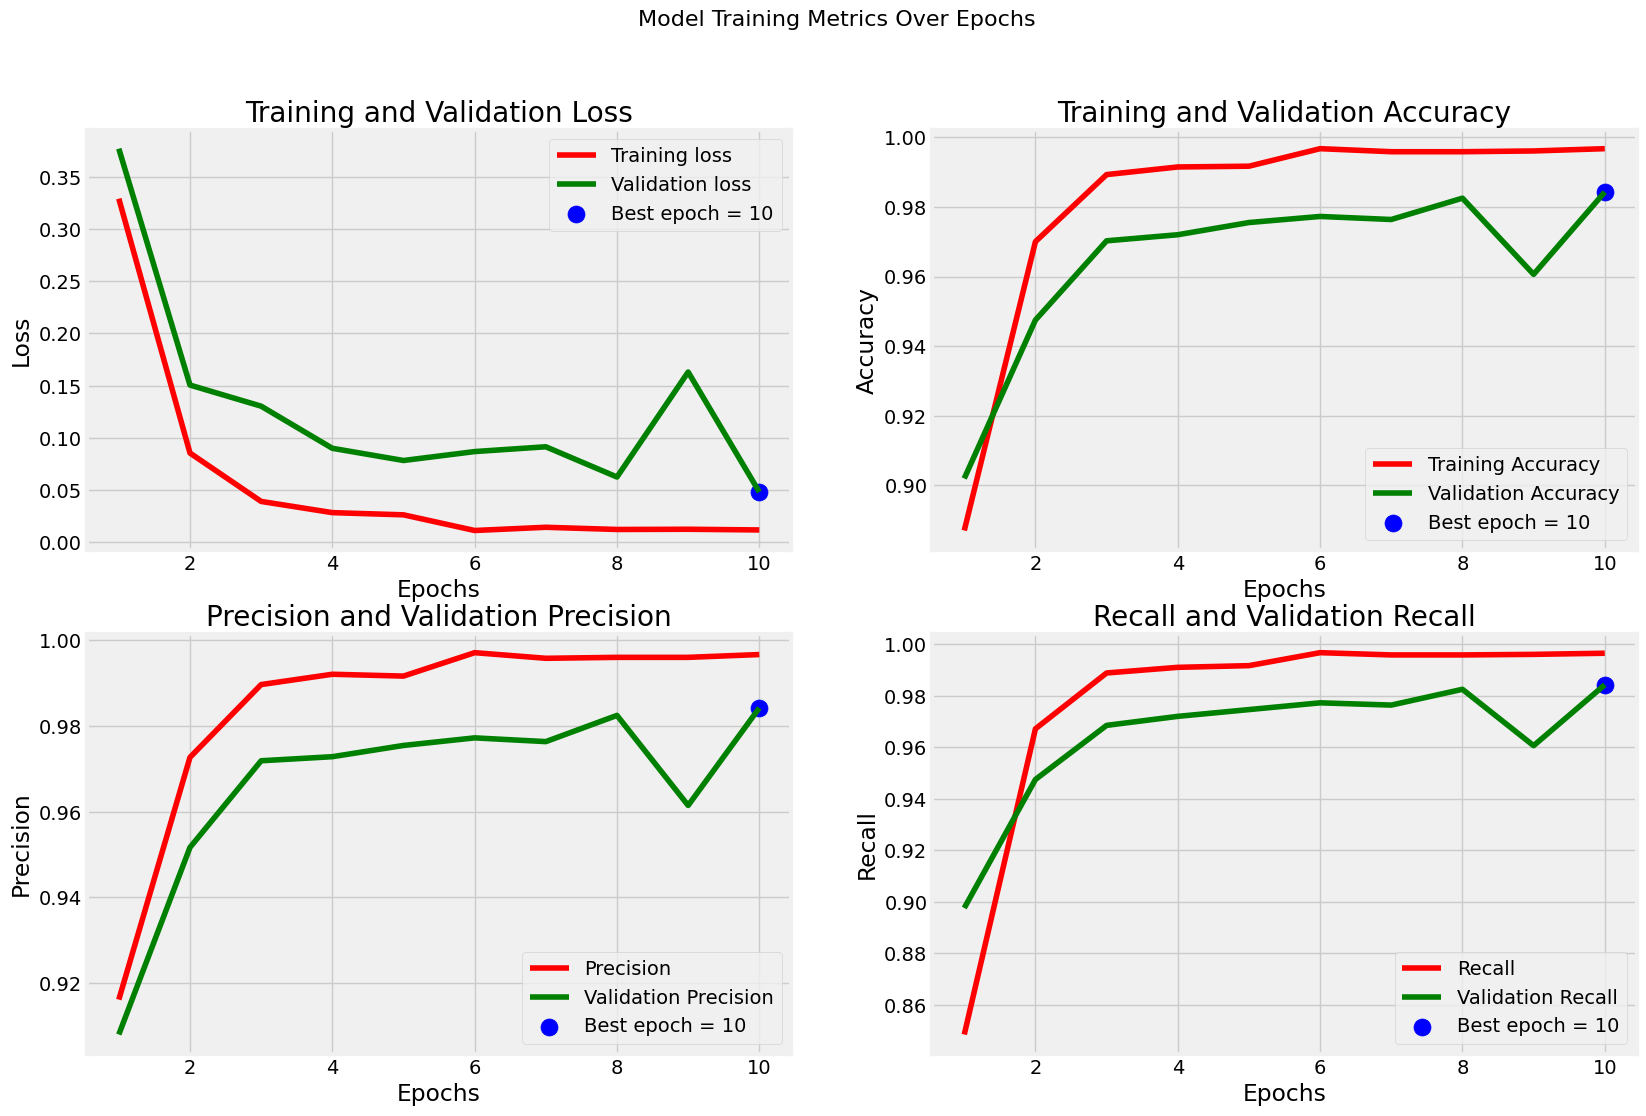

In [ ]:
tr_acc = train_model.history['accuracy']
tr_loss = train_model.history['loss']
tr_per = train_model.history['precision_1']
tr_recall = train_model.history['recall_1']
val_acc = train_model.history['val_accuracy']
val_loss = train_model.history['val_loss']
val_per = train_model.history['val_precision_1']
val_recall = train_model.history['val_recall_1']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [ ]:
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - accuracy: 0.9992 - loss: 0.0036 - precision_1: 0.9992 - recall_1: 0.9992
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.9841 - loss: 0.0445 - precision_1: 0.9841 - recall_1: 0.9841


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 425s 5s/step - accuracy: 0.9853 - loss: 0.0598 - precision_1: 0.9852 - recall_1: 0.9834
Train Loss: 0.0030
Train Accuracy: 99.91%
--------------------
Validation Loss: 0.0483
Validation Accuracy: 98.43%
--------------------
Test Loss: 0.0453
Test Accuracy: 98.93%


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step


In [ ]:
classes=test_gen.class_indices
classes

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

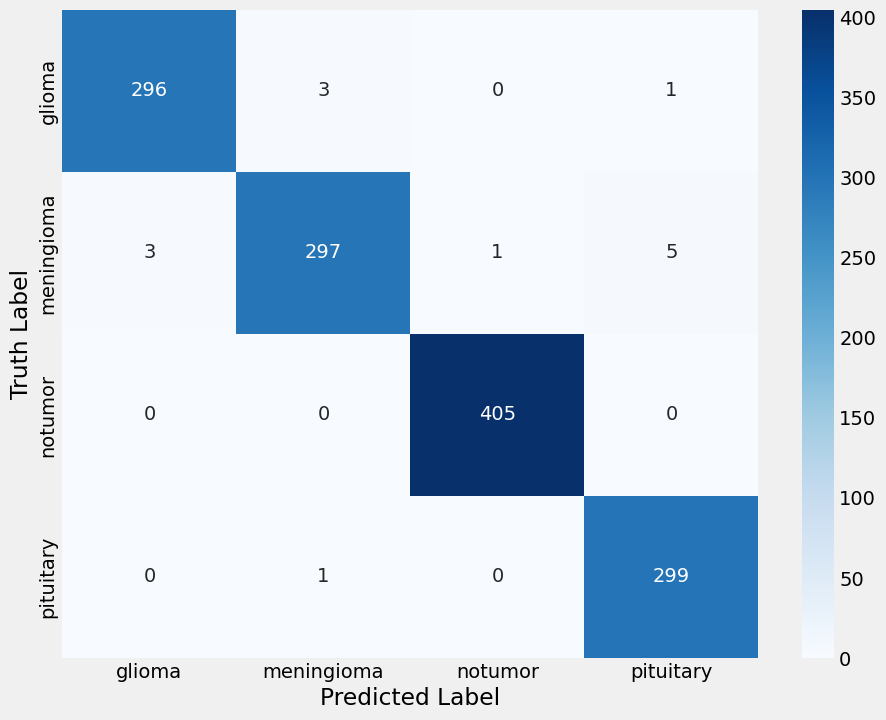

In [ ]:
cm = confusion_matrix(test_gen.classes, y_pred)
labels = list(classes.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
model.save('brain-tumor-xCeptionV0.keras')